In [2]:
import gc
import os
import psutil
import numpy as np
from sys import argv
from functools import partial
from datetime import datetime
from multiprocessing import Pool, cpu_count, get_context

import xarray as xr

os.chdir('/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/models/wxdisco/scripts/')
from funcs import *
from config import *
from plotfuncs import *

import warnings
warnings.filterwarnings('ignore')

tmpdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/models/archive/tmp/'
datadir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/models/archive/'

In [67]:
import matplotlib.pyplot as plt
def newfig(ys=12, xs=12):
    fig = plt.figure(figsize=(ys, xs), facecolor='w')
    ax = fig.add_subplot(111)
    return fig, ax

In [3]:
# Acquire input time if any
init_req = argv[1] if len(argv) == 2 else None
init_req = '2019081509'

# Otherwise determine init time
init_time = get_init(init_req)
print('Retrieving %s forecast initalized %s'%(ensemble, init_time))

Retrieving sref forecast initalized 2019-08-15 09:00:00


In [4]:
def get_grids(init_time):    
    from os import path, stat, remove
    from multiprocessing import Pool, cpu_count, get_context
    from datetime import datetime

    dateH = init_time.strftime('%Y%m%d%H')
    date = init_time.strftime('%Y%m%d')
    
    gribdir = mkdir_p(tmpdir + '%s/models/%s/'%(date, ensemble))
    
    dl_list = []
    dl_start = datetime.utcnow()
    for i, model in enumerate(models):
        for j in range(mcount): 
            # Add future support for other model downloads here
            if ensemble == 'sref':
                if j == 0:
                    member = model + '_ctl'
                elif j <= (mcount-1)/len(models):
                    member = model + '_n%i'%j
                elif j > (mcount-1)/len(models):
                    member = model + '_p%i'%(j-((mcount-1)/len(models)))

            elif ensemble == 'naefs':
                if j == 0:
                    member = model + '_c00'
                else:
                    member = model + '_p%02d'%j
            
            for fhr in range(fhrstart, fhrend+1, fhrstep):
                uuname = '%s%sF%02i.grib2'%(dateH, member, fhr)
                checkfile = gribdir + uuname
                
                # Check if file exists
                if (path.isfile(checkfile)):
                    pass

                    # Check for valid filesize (junk data)
                    if (stat(checkfile).st_size < minsize):
                        # If not, download grids to disk
                        dl_list.append([init_time, fhr, member, checkfile])
                        remove(checkfile)
                    else:
                        pass
                
                else:
                    # If not, download grids to disk
                    dl_list.append(
                        [init_time, fhr, member, checkfile, dl_start])

    # Since most of the download verification is now happening within
    # the worker pool, this isn't actually being utilized as a while loop
    # should right now. Can either finish setting this up to only delete a 
    # sucessful return from the list or remove the loop entirely...
    # though leaving as-is is not a problem either.
    while len(dl_list) > 0:
        cores = len(dl_list) if len(dl_list) < cpu_count()-1 else cpu_count()-1
        
        if mpi_limit is not None:
            cores = cores if cores <= mpi_limit else mpi_limit
        
        print('Downloading %i files on %i cores'%(len(dl_list), cores))
        
        with get_context(spawntype).Pool(cores) as p:
            post_dl_list = p.map(download_grib, dl_list)
            p.close()
            p.join()
        
        [dl_list.remove(dl) for dl in post_dl_list]
        del post_dl_list

    print('Found all files for %s %s'%(ensemble, init_time))
                
    return None

In [5]:
def download_grib(params):
    # Download the desired model run and verify
    import urllib.request
    from sys import exit
    from time import sleep
    from datetime import datetime
    from os import remove, stat, path
    from subprocess import call
    
    minlat, maxlat = 40, 41
    minlon, maxlon = -112, -111

    date = params[0].strftime('%Y%m%d')
    ihr = params[0].hour
    fhr = params[1]
    family = params[2].split('_')[0]
    member = params[2].split('_')[1]
    fpath = params[3]
    start_time = params[4]
    
    # Add future support for other model downloads here
    # Use NCDC NOMADS filterscripts
    # http://nomads.ncep.noaa.gov/
    if ensemble == 'sref':
        base = ('https://nomads.ncep.noaa.gov/cgi-bin/' +
            'filter_sref_132.pl?file=sref')
        mid = '_{}.t{:02d}z.pgrb132.{}.f{:02d}.grib2'.format(
            family, ihr, member, fhr)
        webdir = '&dir=%2Fsref.{}%2F{:02d}%2Fpgrb'.format(date, ihr)
                
    elif ensemble == 'naefs':
        if family == 'gefs':

            base = 'https://nomads.ncep.noaa.gov/cgi-bin/filter_gens_0p50.pl'
            mid = '?file=ge{}.t{:02d}z.pgrb2a.0p50.f{:03d}'.format(
                member, ihr, fhr)
            webdir = '&dir=%2Fgefs.{}%2F{:02d}%2Fpgrb2ap5'.format(date, ihr)

        elif family == 'cmce':
            base = 'https://nomads.ncep.noaa.gov/cgi-bin/filter_cmcens.pl'
            mid = '?file=cmc_ge{}.t{:02d}z.pgrb2a.0p50.f{:03d}'.format(
                member, ihr, fhr)
            webdir = '&dir=%2Fcmce.{}%2F{:02d}%2Fpgrb2ap5'.format(date, ihr)
    
    mvars = ('&lev_1000_mb=on&lev_100_mb=on&lev_10_m_above_ground=on&lev_200_mb=on' + 
            '&lev_250_mb=on&lev_2_m_above_ground=on&lev_300_mb=on&lev_400_mb=on&lev_500_mb=on' + 
            '&lev_50_mb=on&lev_700_mb=on&lev_850_mb=on&lev_925_mb=on&lev_surface=on')

    mlevs = ('&var_APCP=on&var_CAPE=on&var_HGT=on&var_PRES=on&var_PRMSL=on&var_PWAT=on' +
             '&var_RH=on&var_TMP=on&var_UGRD=on&var_VGRD=on')
    
    subset = ('&subregion=&leftlon={}&rightlon={}'.format(
        minlon, maxlon) + '&toplat={}&bottomlat={}'.format(
        maxlat, minlat))

    url = base + mid + mvars + mlevs + subset + webdir

    # Download the grib to disk
    while not path.isfile(fpath):
        try:
            urllib.request.urlretrieve(url, fpath)

        except OSError:
            # Sometimes urllib struggles. Before totally giving up, try this
            # the old fashioned way first...
            curlcommand = 'curl -s -m {} -o {} {}'.format(timeout, fpath, url)
            call(curlcommand, shell=True)

        try:
            fsize = stat(fpath).st_size
        except:
            print('FILE NOT FOUND Data not yet available. Waiting', 
                wait, 'seconds...')
        else:
            if (fsize > minsize):
                pass
            else:
                print('FSIZE ERROR JUNK FILE Data not yet available. Waiting', 
                    wait, 'seconds...')
                remove(fpath)
                sleep(wait)
                
                now = datetime.utcnow()
                if ((now-start_time).days >= 1 
                    or (now-start_time).seconds > killtime * 3600):
            
                    exit()

    return params

In [6]:
def gen_paths(init_time):
    from glob import glob
    from os import remove

    dateH = init_time.strftime('%Y%m%d%H')
    date = init_time.strftime('%Y%m%d')

    # Purge preexisting index files if any exist and start fresh
    try:
        idxpaths = glob(tmpdir + '%s/models/%s/%s*.idx'%(
            date, ensemble, dateH))
        [remove(idx) for idx in idxpaths]
    except:
        pass
    else:
        print('\nRemoved preexisting index files')

    # Read in the data files [one member at a time]
    member_paths = list()
    for i, model in enumerate(models):
        for j in range(mcount):
            # Add future support for other model downloads here
            if ensemble == 'sref':
                if j == 0:
                    member = model + '_ctl'
                elif j <= (mcount-1)/len(models):
                    member = model + '_n%i'%j
                elif j > (mcount-1)/len(models):
                    member = model + '_p%i'%(j-((mcount-1)/len(models)))

            elif ensemble == 'naefs':
                if j == 0:
                    member = model + '_c00'
                else:
                    member = model + '_p%02d'%j

            # Adapt this for init time
            member_paths.append([member, np.sort(glob(tmpdir +
                '%s/models/%s/%s%s*.grib2'%(date, ensemble, dateH, member)))])
        
    return member_paths

In [8]:
# Do the downloading
get_grids(init_time)

# Gather paths to member files
mpaths = gen_paths(init_time)

Found all files for sref 2019-08-15 09:00:00

Removed preexisting index files


In [9]:
def openmfd(paths, lset, cdim, stepType):
    """ Dask-free """
    # paths[0] gives the member name
    # paths[1] gives a list of filepaths by hour

    # Open each forecast hour as a dataset...
    datasets = [xr.open_dataset(
            path, engine='cfgrib', #concat_dim=cdim, 
            backend_kwargs={"filter_by_keys":{"typeOfLevel":lset, "stepType":stepType}}) 
                for path in paths[1]]

    if stepType == 'accum':
    
        if ( (ensemble == 'naefs') & (lset == 'surface') ):
            # Fix the silly issue where CMCE calls tp unknown
            tp = 'unknown' if 'cmce' in str(paths[1]) else 'tp'

            # The NAEFS doesn't include a tp field at hour 0
            # We don't need orog so just swap it for tp with zeros
            datasets[0] = datasets[0].rename({'orog':tp})
            datasets[0][tp].values = np.zeros(datasets[0][tp].shape)

        #...then concatenate them into a single member dataset
        dataset = xr.concat(datasets, dim=cdim)
        dataset = dataset.assign_coords(member_id=paths[0])

        if ( ('cmce' in str(paths[1])) & (lset == 'surface') ):
            dataset = dataset.rename({'unknown':'tp'})

        # ARW comes in as a total accumulated precip to fhr
        # Deconstruct into 3-hour precip to match the NMB
        if ((lset == 'surface') & ('arw' in paths[0])):
            print("Deconstructing %s from accumulated to step precip"%paths[0])
            arw_tp = np.zeros(dataset.tp.shape)
            arw_tp[0,:,:] = dataset.tp[0,:,:]
            for i in range(1, arw_tp.shape[0]):    
                arw_tp[i,:,:] = dataset['tp'][i,:,:] - dataset['tp'][i-1,:,:]

            dataset['tp'].values = arw_tp
            
    else:
        dataset = xr.concat(datasets, dim=cdim)

    # Clean up the coordinate names a bit
    if lset == 'surface':
        del dataset['surface']
    elif lset == 'isobaricInhPa':
        dataset = dataset.rename({'isobaricInhPa':'level'})
        
    del dataset['step'], dataset['time']

    return dataset

In [65]:
# Read members without dask distributed (slow)
print('\nReading individual member files')

cores = len(mpaths) if len(mpaths) <= cpu_count() else cpu_count()
mpi_limit = mpi_limit if mpi_limit is not None else 999
cores = cores if cores <= mpi_limit else mpi_limit

with get_context(spawntype).Pool(cores) as p:
    openmfd_wrap = partial(openmfd, lset='surface', cdim='valid_time', stepType='instant')
    _surface_inst = p.map(openmfd_wrap, mpaths)
    
    openmfd_wrap = partial(openmfd, lset='surface', cdim='valid_time', stepType='accum')
    _surface_accum = p.map(openmfd_wrap, mpaths)
    
    openmfd_wrap = partial(
    openmfd, lset='isobaricInhPa', cdim='valid_time', stepType='instant')
    _isobaric = p.map(openmfd_wrap, mpaths)
    
    p.close()
    p.join()
    
# Gather to single xarray
print('Concatenating members...', end='')
surface_inst = concat_clean_xarray(_surface_inst, cdim='number')
surface_accum = concat_clean_xarray(_surface_accum, cdim='number')

for k in list(surface_inst.keys()):
    if k in list(surface_accum.keys()):
        del surface_accum[k]
    
surface = xr.Dataset.merge(surface_inst, surface_accum)
isobaric = concat_clean_xarray(_isobaric, cdim='number')

[f.close() for f in _surface_inst]
[f.close() for f in _surface_accum]
[f.close() for f in _isobaric]
del _surface_inst, _surface_accum, _isobaric
print('...done')

sitelat, sitelon = 40.77, -111.97
lats, lons = surface.lat.values, surface.lon.values

dist = []
for i in range(lats.shape[0]):
    for j in range(lats.shape[1]):
        _lat, _lon = lats[i, j], lons[i, j]
        _dist = abs(sitelat-_lat) + abs(sitelon-_lon)
        dist.append([_dist, i, j])
dist = np.array(dist)
i, j = dist[dist[:,0].argsort()][0, 1:].astype(int)
lat, lon = lats[i, j], lons[i, j]

surface, isobaric = surface.isel(x=j, y=i), isobaric.isel(x=j, y=i)


Reading individual member files
Deconstructing arw_n6 from accumulated to step precip
Deconstructing arw_p6 from accumulated to step precip
Deconstructing arw_p5 from accumulated to step precip
Deconstructing arw_n4 from accumulated to step precip
Deconstructing arw_n3 from accumulated to step precip
Deconstructing arw_ctl from accumulated to step precip
Deconstructing arw_p3 from accumulated to step precip
Deconstructing arw_p4 from accumulated to step precip
Deconstructing arw_n2 from accumulated to step precip
Deconstructing arw_n5 from accumulated to step precip
Deconstructing arw_p1 from accumulated to step precip
Deconstructing arw_n1 from accumulated to step precip
Deconstructing arw_p2 from accumulated to step precip
Concatenating members......done


In [66]:
surface, isobaric

(<xarray.Dataset>
 Dimensions:    (member: 26, time: 30)
 Coordinates:
     lat        float64 40.84
     lon        float64 -112.0
   * time       (time) datetime64[ns] 2019-08-15T09:00:00 ... 2019-08-19
   * member     (member) int64 1 2 3 4 5 6 7 8 9 ... 18 19 20 21 22 23 24 25 26
     member_id  (member) <U7 'arw_ctl' 'arw_n1' 'arw_n2' ... 'nmb_p5' 'nmb_p6'
 Data variables:
     sp         (member, time) float32 85259.0 85291.0 ... 84730.0 84642.0
     orog       (member, time) float32 1499.0 1499.0 1499.0 ... 1540.0 1540.0
     cape       (member, time) float32 0.0 0.0 0.0 580.0 ... 0.0 0.0 20.0 0.0
     t          (member, time) float32 292.60004 289.4 295.3 ... 312.9 308.9
     tp         (member, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
 Attributes:
     GRIB_edition:            2
     GRIB_centre:             kwbc
     GRIB_centreDescription:  US National Weather Service - NCEP 
     GRIB_subCentre:          2
     Conventions:             CF-1.7
     institution:

In [136]:
plevs = [0.05, 0.1, 0.5, 0.9, 0.95]
_t = (surface.t-273.15).quantile(plevs, dim='member')
_cape = surface.cape.quantile(plevs, dim='member')
_sp = (surface.sp/100.).quantile(plevs, dim='member')
_t700 = isobaric.t.sel(level=700).quantile(plevs, dim='member')
_z700 = isobaric.gh.sel(level=700).quantile(plevs, dim='member')
_z500 = isobaric.gh.sel(level=500).quantile(plevs, dim='member')

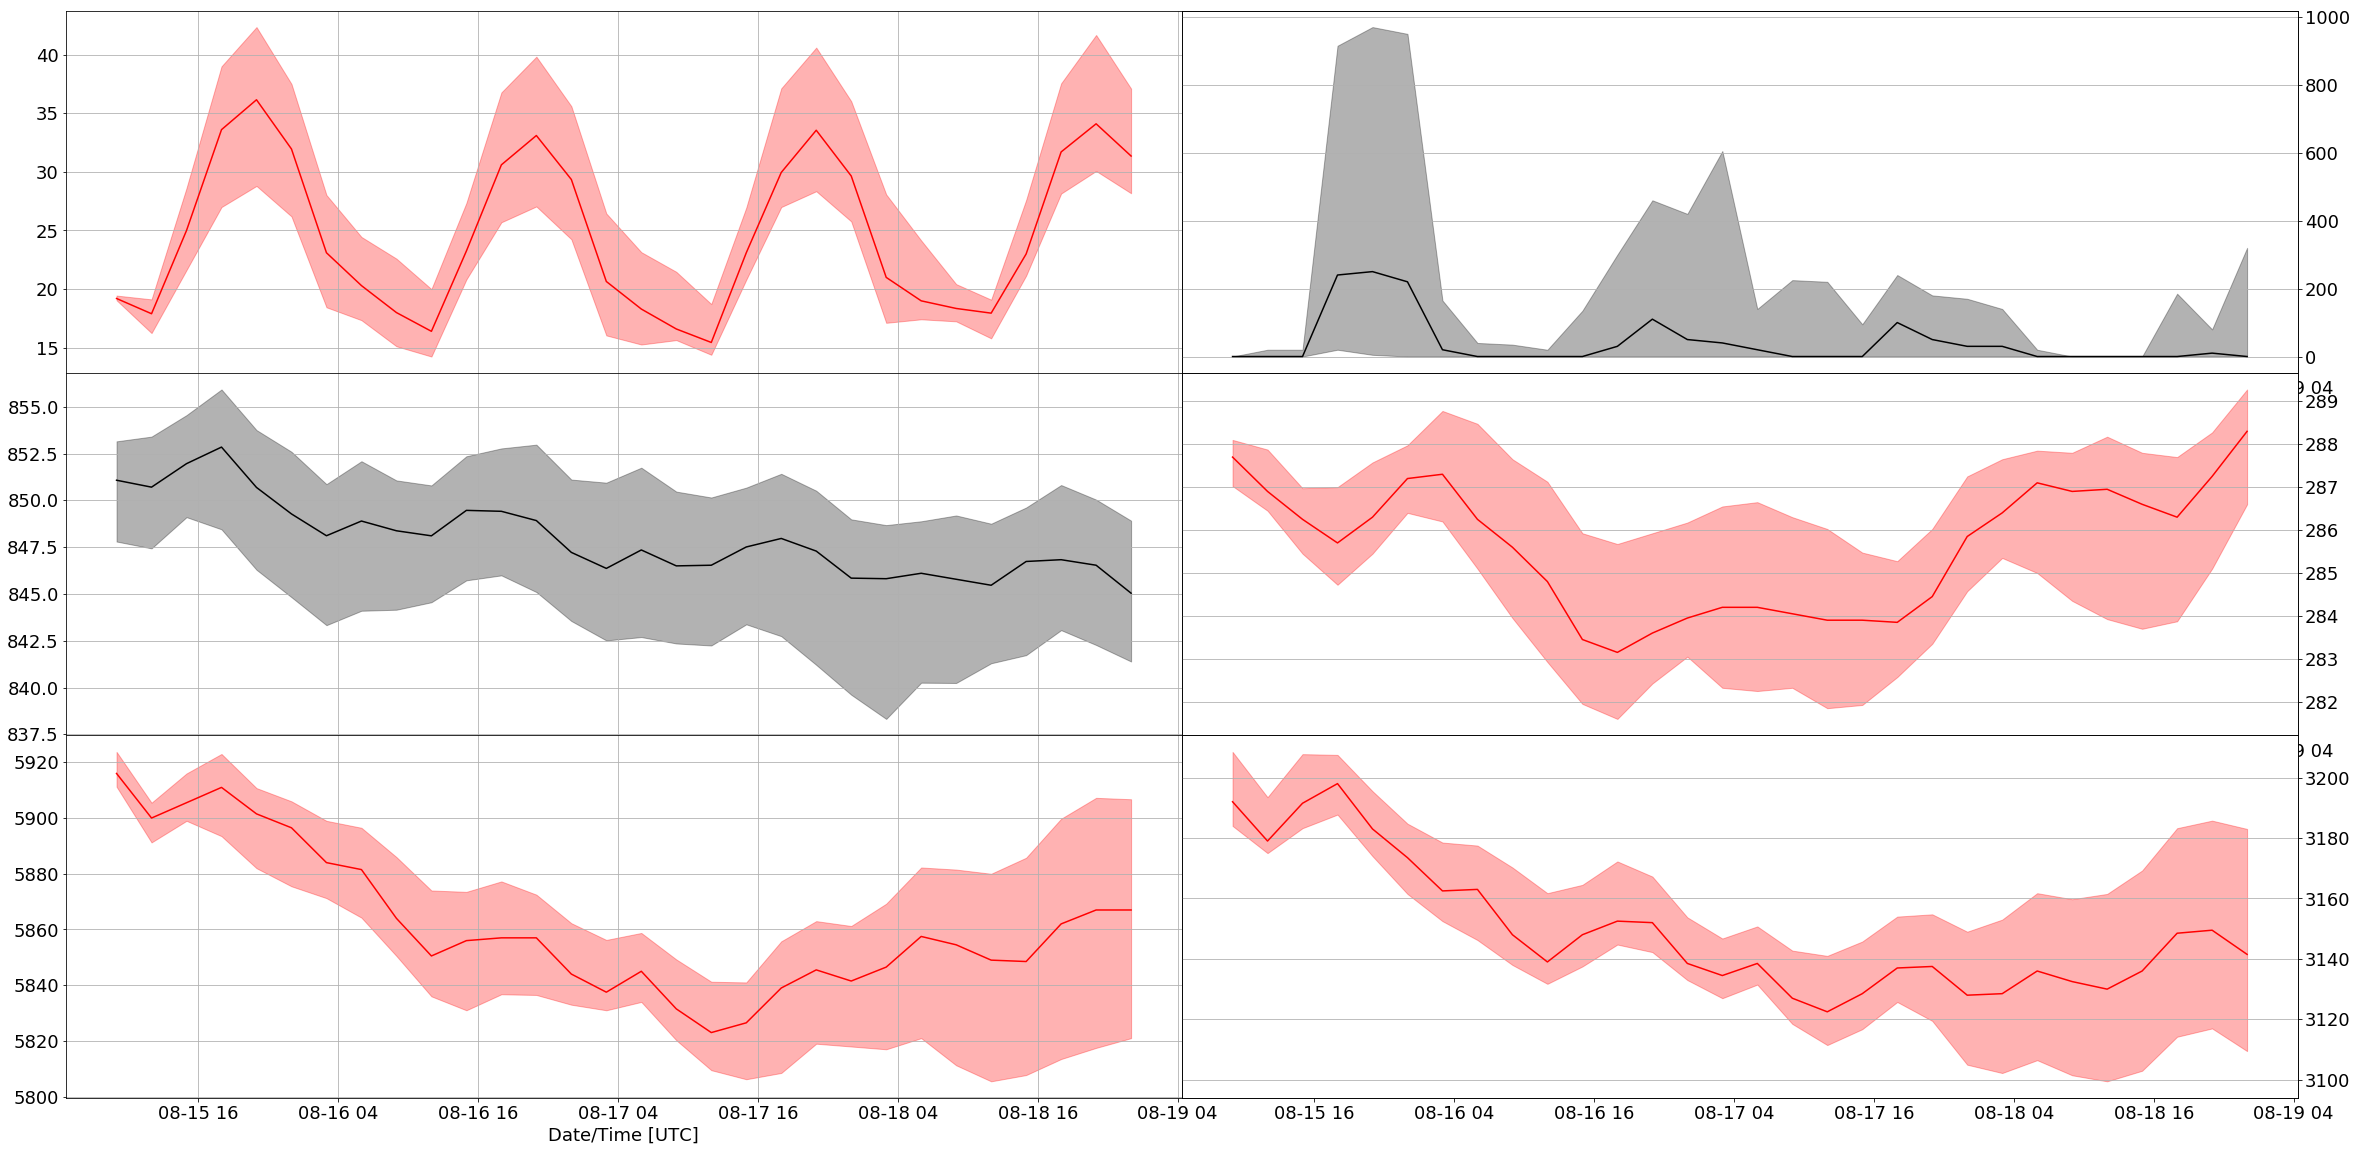

In [138]:
time = surface.time.values

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(40, 20), facecolor='w')
fig.subplots_adjust(hspace=0, wspace=0)

axs = []
for i in range(6):
    ax = fig.add_subplot(3, 2, i+1)
    
    if i in [1, 3, 5]:
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax = ax.twinx()
    
    ax.grid(True)
    ax.set_xlabel('Date/Time [UTC]')
    
    axs.append(ax)
    
    
axs[0].plot(time, _t.sel(quantile=.50), c='r')
axs[0].fill_between(time, _t.sel(quantile=.05), _t.sel(quantile=.95), color='r', alpha=0.3)

axs[1].plot(time, _cape.sel(quantile=.50), c='k')
axs[1].fill_between(time, _cape.sel(quantile=.05), _cape.sel(quantile=.95), color='k', alpha=0.3)

axs[2].plot(time, _sp.sel(quantile=0.5), c='k')
axs[2].fill_between(time, _sp.sel(quantile=.05), _sp.sel(quantile=.95), color='k', alpha=0.3)

axs[3].plot(time, _t700.sel(quantile=.50), c='r')
axs[3].fill_between(time, _t700.sel(quantile=.05), _t700.sel(quantile=.95), color='r', alpha=0.3)

axs[4].plot(time, _z500.sel(quantile=.50), c='r')
axs[4].fill_between(time, _z500.sel(quantile=.05), _z500.sel(quantile=.95), color='r', alpha=0.3)

axs[5].plot(time, _z700.sel(quantile=.50), c='r')
axs[5].fill_between(time, _z700.sel(quantile=.05), _z700.sel(quantile=.95), color='r', alpha=0.3)

In [142]:
testpath = '/scratch/general/lustre/ldm/rt/20190815/models/sref/2019081509/'
test = xr.open_dataset(testpath + '2019081509_arw_p4_downscaled.nc')
lats, lons = test.lat.values, test.lon.values

print(test)

<xarray.Dataset>
Dimensions:    (time: 30, x: 3001, y: 2392)
Coordinates:
  * time       (time) float64 1.566e+18 1.566e+18 ... 1.566e+18 1.566e+18
    lat        (y, x) float32 29.99583 29.99583 29.99583 ... 49.920822 49.920822
    lon        (y, x) float32 -125.004166 -124.995834 ... -100.01251 -100.00417
    member     float64 ...
    member_id  object ...
Dimensions without coordinates: x, y
Data variables:
    slr        (time, y, x) float32 ...
    dqpf       (time, y, x) float32 ...
    snow       (time, y, x) float32 ...
Attributes:
    description:  Downscaled {} QPF/Snow Grids Init SREF UTC
    history:      Created 2019-08-15 13:23:04.915757
    source:       University of Utah - Steenburgh Research Group


In [151]:
a = abs( lats - sitelat ) + abs( lons - sitelon )
i, j = np.unravel_index(a.argmin(), a.shape)

test.sel(x=j, y=i)

<xarray.Dataset>
Dimensions:    (time: 30)
Coordinates:
  * time       (time) float64 1.566e+18 1.566e+18 ... 1.566e+18 1.566e+18
    lat        float32 40.77083
    lon        float32 -111.97084
    member     float64 ...
    member_id  object ...
Data variables:
    slr        (time) float32 ...
    dqpf       (time) float32 ...
    snow       (time) float32 ...
Attributes:
    description:  Downscaled {} QPF/Snow Grids Init SREF UTC
    history:      Created 2019-08-15 13:23:04.915757
    source:       University of Utah - Steenburgh Research Group